In [124]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import pingouin as pg

In [125]:
dataset = ["yaz", "bakery","m5", "SID"]

best_results = pd.DataFrame()
cv_results = pd.DataFrame()

for d in dataset:
    best_results_temp = pd.read_csv("Results/best_results_"+d+".csv.zip")
    cv_results_temp = pd.read_csv("Results/cv_results_"+d+".csv.zip")
    best_results = pd.concat([best_results, best_results_temp],ignore_index=True)
    cv_results = pd.concat([cv_results, cv_results_temp],ignore_index=True)

## Load Results

## Best results

In [126]:
best_results['feature combi'] = best_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
best_results['feature combi'] = best_results['feature combi'].str.replace('_m5', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_bakery', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_yaz', '')

In [127]:
best_results.drop(columns=["cu","co"], inplace=True)

In [128]:
# create column for rank
best_results["rank"] = best_results.groupby(["sl", "group", "dataset", "feature combi"])["coefficient of prescriptiveness"].rank("min", ascending=False)

In [129]:
# base case results
base_case = best_results[(best_results["sl"]==0.90) & (best_results["feature combi"]=="calendar, lag")]

# select the best model per group
best_model_per_group = best_results.loc[best_results.groupby(["sl", "group", "dataset", "feature combi"])['coefficient of prescriptiveness'].idxmax()]
best_model_per_group['model'] = pd.Categorical(best_model_per_group['model'], ["SAA", "KNNW", "DTW", "RFW", "GKW", "LR", "DL"])

# select the best model per group from for base cas
best_model_per_group_BC = best_model_per_group[(best_model_per_group["sl"]==0.9) & (best_model_per_group["feature combi"]=="calendar, lag")]


## CV Results

In [130]:
cv_results['feature combi'] = cv_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_m5', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_bakery', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_yaz', '')

In [131]:
# select columns
cv_results = cv_results[['mean_test_score', 'dataset', 'feature combi',
       'group', 'model', 'sl', 'params']]

In [132]:
# select best models per parameter gird
best_model_per_grid = cv_results.loc[cv_results.groupby(["model", "group", "dataset", "feature combi", "sl"])["mean_test_score"].idxmax()]

# create column for rank
best_model_per_grid["rank"] = best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])["mean_test_score"].rank("min", ascending=False)

# select the best model per group from CV results
best_cv_model_per_group = best_model_per_grid.loc[best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])['mean_test_score'].idxmax()]

# select columns
best_cv_model_per_group= best_cv_model_per_group.iloc[:,-10:]

# select the best model per group from CV results for base case
best_cv_model_per_group_bc = best_cv_model_per_group[(best_cv_model_per_group["feature combi"]=="calendar, lag") & (best_cv_model_per_group["sl"]==0.9)]

# get performance of the best cv model on the test data
performance_of_best_cv_model_on_test_data = best_results.merge(best_cv_model_per_group, on=["group", "dataset", "model", "sl", "feature combi"])

# Settings

In [133]:
datasets = best_results["dataset"].unique()

In [134]:
model_order = ["SAA", "KNNW", "DTW", "RFW", "GKW", "LR", "DL"]
cop_model_order = ["KNNW", "DTW", "RFW", "GKW", "LR", "DL"]

In [155]:
# color palette for different models
p = {"SAA": "xkcd:red", "RFW": "xkcd:blue", "DTW": "xkcd:sky blue", "KNNW":"xkcd:pinkish", "GKW": "xkcd:goldenrod", "LR": "xkcd:green", "DL": "xkcd:light brown", "model selection": "xkcd:orange","selection": "xkcd:orange"}
#p = {"SAA": sns.color_palette("Set2",8)[0], "RFW": sns.color_palette("Set2",8)[1], "DTW": sns.color_palette("Set2",8)[2], "KNNW":sns.color_palette("Set2",8)[3], "GKW": sns.color_palette("Set2",8)[4], "LR": sns.color_palette("Set2",8)[5], "DL": sns.color_palette("Set2",8)[6], "ES": sns.color_palette("Set2",8)[7]}

# standard column for all plots
c = "#1f77b4"


# Main plots

## Model comparison CoP for base case

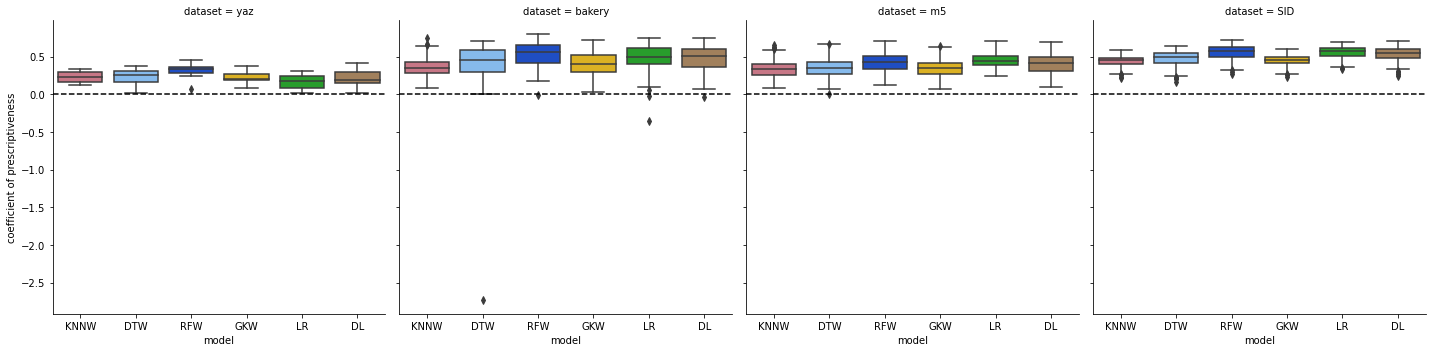

In [13]:
fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=base_case, kind="box", palette=p, col="dataset", order=cop_model_order)
for i in range(datasets.shape[0]):
    fig.axes[0][i].axhline(0, color="black", linestyle='--')

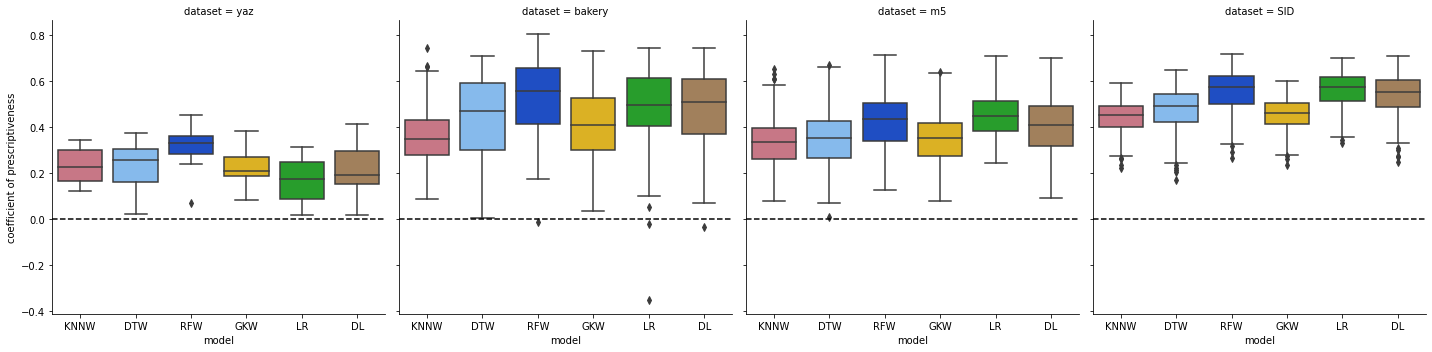

In [14]:
df = base_case.drop(base_case[(base_case['coefficient of prescriptiveness'] < -0.5)].index)
fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=df, kind="box", palette=p, col="dataset", order=cop_model_order)
for i in range(datasets.shape[0]):
    fig.axes[0][i].axhline(0, color="black", linestyle='--')
    

In [15]:
fig.savefig("plots/model comparison.png") 

## Rank plots

### Rank one overall

In [16]:
df = best_model_per_group["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

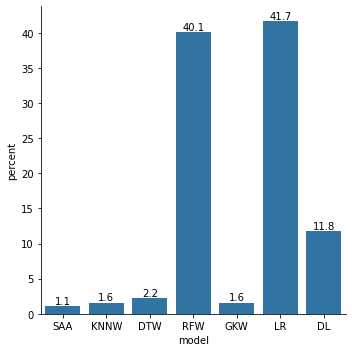

In [17]:
fig = sns.catplot(data=df, x="model",y='percent',kind='bar', color=c, order = model_order)
for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [18]:
fig.savefig("plots/rank_one_overall.png")

### Rank one overall by dataset

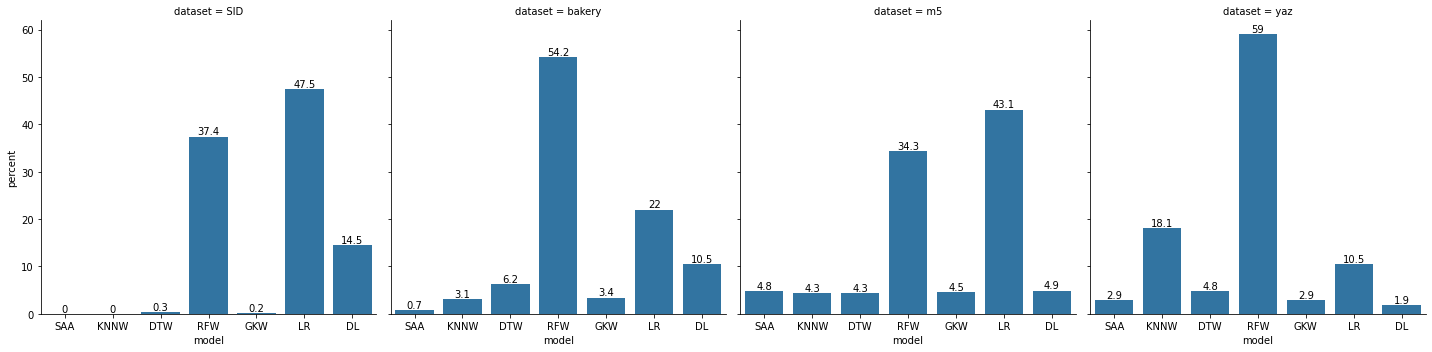

In [19]:
df = best_model_per_group.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

fig = sns.catplot(data=df, x="model",y='percent',col="dataset",kind='bar', color=c, order = model_order)

for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [20]:
fig.savefig("plots/rank_one_overall_per_dataset.png")

### Rank one for base case

In [21]:
df = best_model_per_group_BC["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

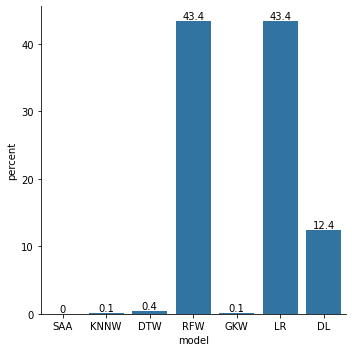

In [22]:
fig = sns.catplot(data=df, x="model",y='percent',kind='bar', color=c, order = model_order)
for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [23]:
fig.savefig("plots/rank_one_base_case.png")

### Rank one by datasets for base case

In [24]:
df = best_model_per_group_BC.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

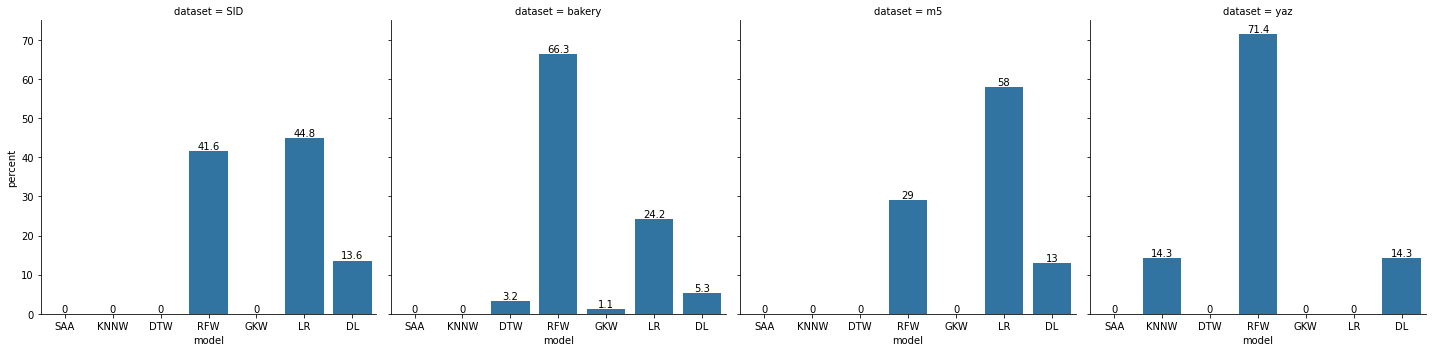

In [25]:
fig = sns.catplot(data=df, x="model",y='percent',col="dataset",kind='bar', color=c, order = model_order)

for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [26]:
fig.savefig("plots/rank_one_per_dataset_base_case.png")

## Line Plots 

### Performance variation of service levels

calendar
calendar, lag
calendar, lag, special


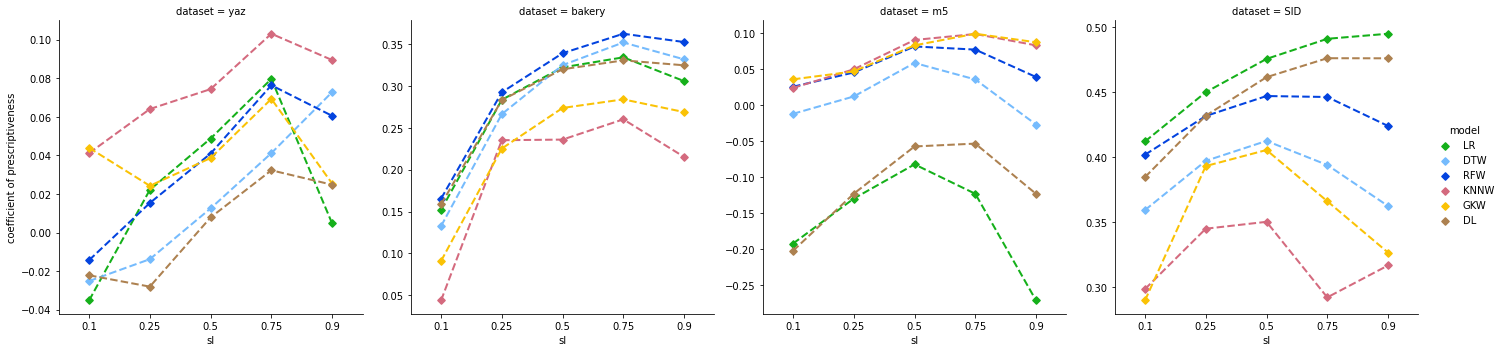

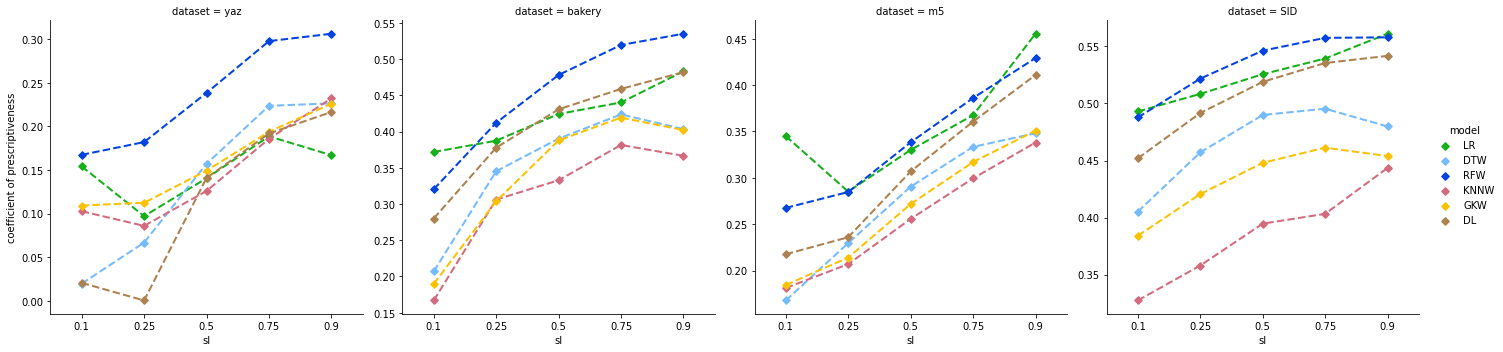

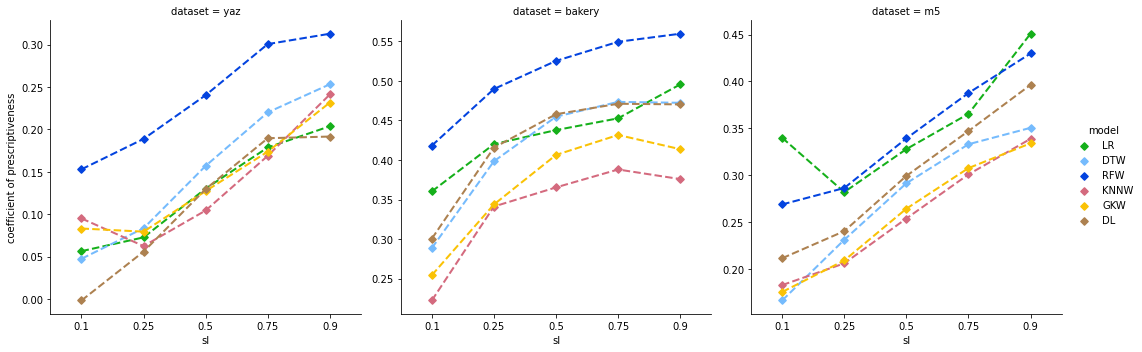

In [27]:
##################
### USER INPUT ###
##################

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select feature combis to plot
features = [
            "calendar",
            "calendar, lag",
            "calendar, lag, special"
           ]

for f in features:
    print(f)
    fig = sns.catplot(x="sl", hue="model", y=metric, data=best_results[(best_results["feature combi"]==f) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci=None, sharey=False, 
                      palette=p, linestyles='--', markers='D', scale=0.75
                     )
    fig.figure.savefig("Plots/SL_variation_"+metric+" "+f+".png")  

### Performance variation of features

0.1
0.25
0.5
0.75
0.9


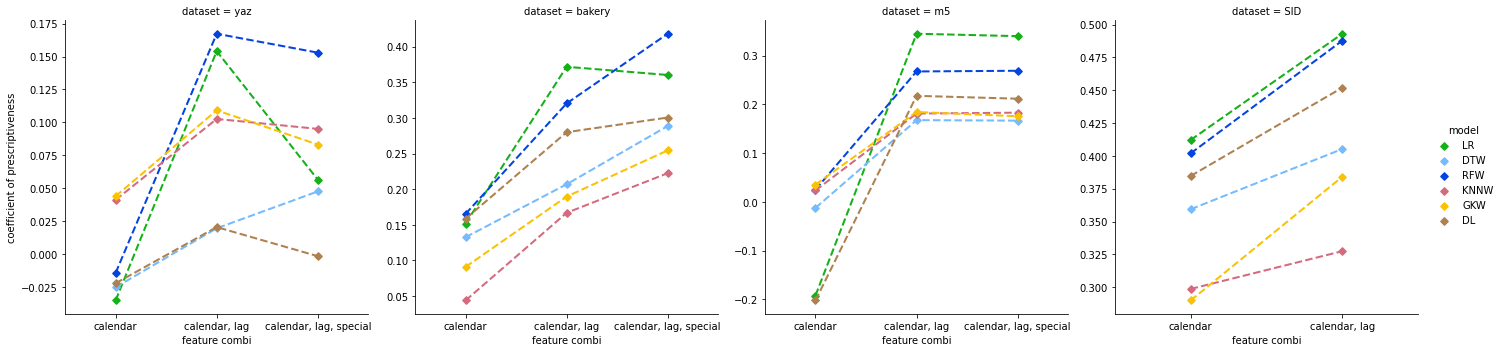

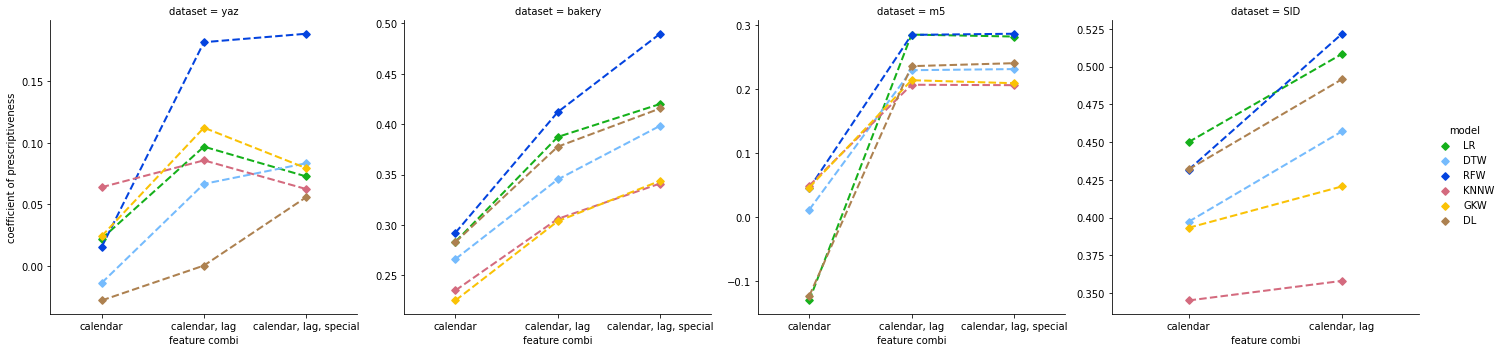

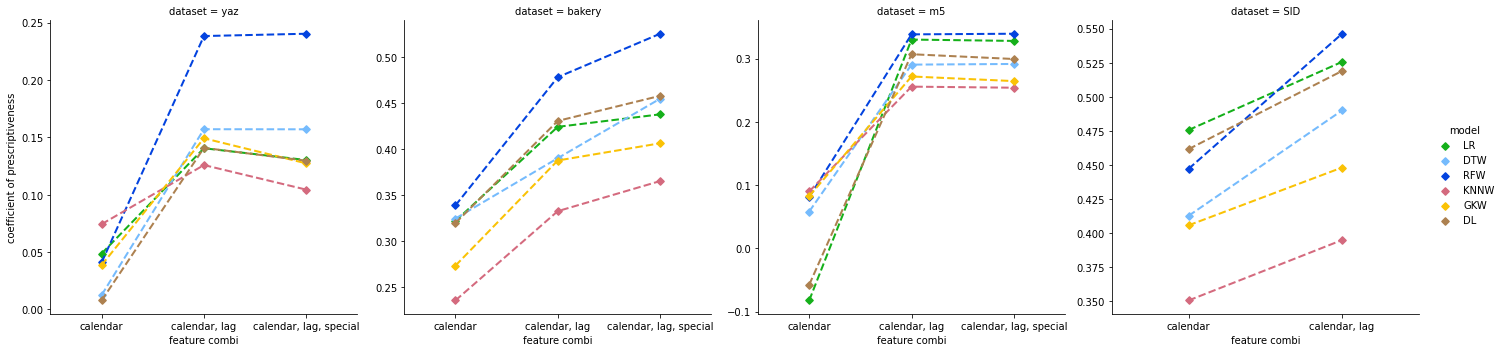

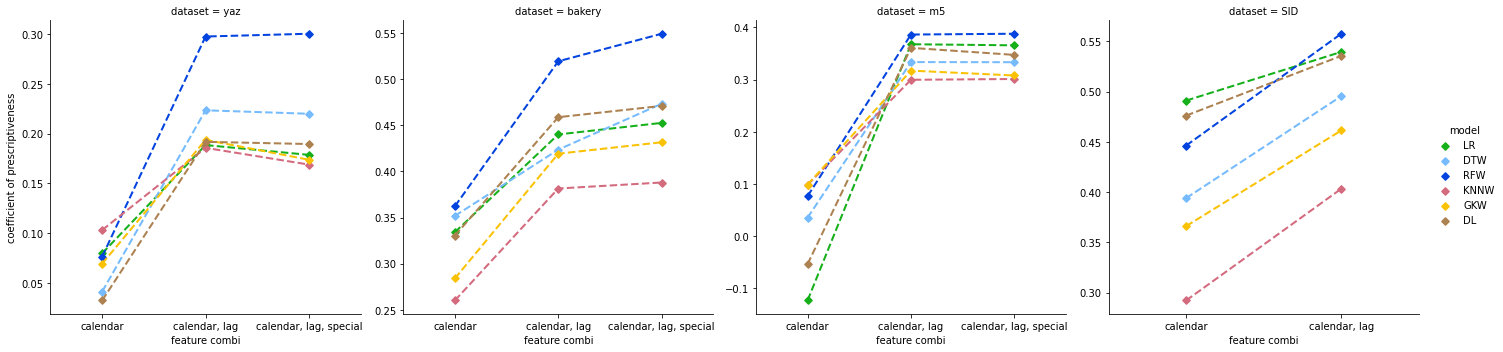

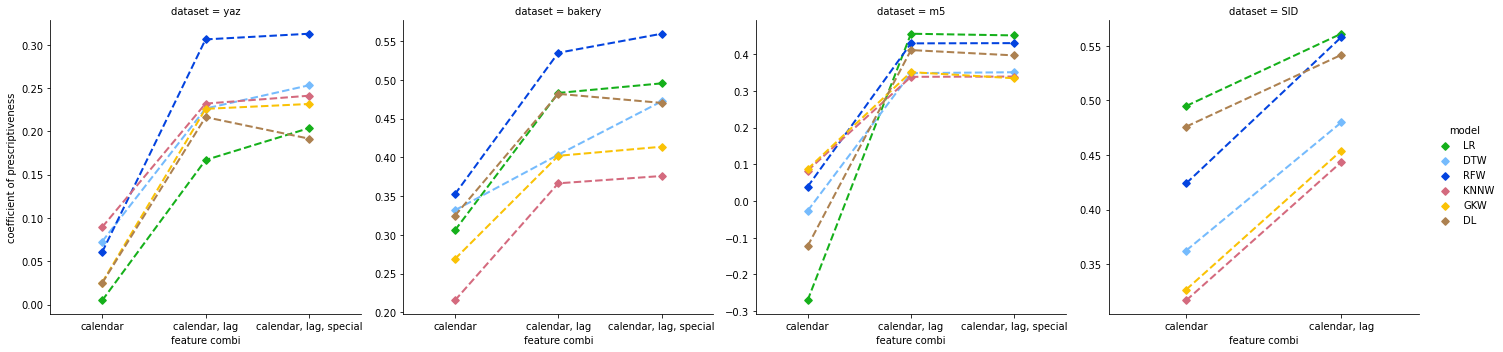

In [28]:
##################
### USER INPUT ###
##################

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select SLs to plot. Possible are: 0.1, 0.25, 0.5, 0.75, 0.9
SLs = [0.1, 0.25, 0.5, 0.75, 0.9]

for SL in SLs:
    print(SL)
    fig = sns.catplot(x="feature combi", hue="model", y= metric, data=best_results[(best_results["sl"]==SL) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci=None, sharey=False, sharex=False, 
                      palette=p, linestyles='--', markers='D', scale=0.75)
    
    fig.figure.savefig("Plots/feature_variation_"+metric+" "+str(SL)+".png") 

## Gap to optimality

In [136]:
##################
### USER INPUT ###
##################

# Select SL to plot. Possible are: 0.1, 0.25, 0.5, 0.75, 0.9
SL = 0.9

# Select feature combi to plot. 
features = "calendar, lag"
 
# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
# Note: The models are plotted in the given order on the x-axis
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

X_axis_label = "∆C"
y_axis_label = "Selected Model"

# ------------------------------------------------------------------------------------

order = ["model selection"] + models

df = pd.DataFrame()

# all test results 
df1 = best_results[["model", "sl", "group", "dataset", "feature combi", "average costs"]]

# group my model
df2 = df1.groupby(["model"])

df3 = best_model_per_group[["model", "sl", "group", "dataset", "feature combi", "average costs"]]

for model in models:   
    df4 = df2.get_group(model)
    df5 = df4.merge(df3, on=["group", "dataset", "sl", "feature combi"])
    df5[X_axis_label] = 1-df5["average costs_x"]/df5["average costs_y"]
    df5[y_axis_label] = model    
    df = pd.concat([df, df5])

df4 = performance_of_best_cv_model_on_test_data[["model", "sl", "group", "dataset", "feature combi", "average costs"]]
df5 = df4.merge(df3, on=["group", "dataset", "sl", "feature combi"])
df5[X_axis_label] = 1-df5["average costs_x"]/df5["average costs_y"]
df5[y_axis_label] = "model selection"
df = pd.concat([df, df5])

df = df[(df["sl"]==SL) & (df["feature combi"]==features)] 

In [148]:
# compute gap to optimality means

# overall
df_means_all = df.groupby(['Selected Model'])['∆C'].mean()
df_means_all = df_means_all.reset_index()

df_means_all.sort_values('∆C', ascending=False, inplace=True)
df_means_all.reset_index(drop=True, inplace=True)

df_means_all.loc[df_means_all['Selected Model']=='model selection','Selected Model']='selection'

# per dataset
df_means_dataset = df.groupby(['dataset', 'Selected Model'])['∆C'].mean()
df_means_dataset = df_means_dataset.reset_index()

# sort by method with lowest mean
df_means_dataset.sort_values(['dataset','∆C', 'Selected Model'], ascending=False, inplace=True)
df_means_dataset.reset_index(drop=True, inplace=True)

df_means_dataset.loc[df_means_dataset['Selected Model']=='model selection','Selected Model']='selection'

In [151]:
#### Compute Wilcoxon signed-rank test statistics #####

wilcox = []

# compute Wilcoxon signed-rank test per dataset
for d in df.dataset.unique():
    
    df_sel = df.loc[(df['Selected Model']=='model selection')&(df['dataset']==d)]
    df_sel.sort_values(by='group', inplace=True)
    
    for m in models:
        
        if m == 'selection':
            break
        
        sel_model = df.loc[(df['Selected Model']==m)&(df['dataset']==d)]
        sel_model.sort_values(by='group', inplace=True)
        
        try:
            w, p_v = pg.wilcoxon(df_sel['∆C'],sel_model['∆C'], alternative='greater').loc['Wilcoxon',['W-val', 'p-val']]
        except:
            # if model selection and fixed model are equal, wilcoxon test will fail
            w, p_v = ('NA', 'NA')
            
        wilcox.append({'Dataset':d, 'Selected Model':m , 'test_statistic':w, 'p_value':p_v})

# compute Wilcoxon signed-rank test across datasets
df_sel = df.loc[(df['Selected Model']=='model selection')]
df_sel.sort_values(by='group', inplace=True)       
        
for m in models:
    
        if m == 'selection':
            break
        
        sel_model = df.loc[(df['Selected Model']==m)]
        sel_model.sort_values(by='group', inplace=True)
        
        try:
            w, p_v = pg.wilcoxon(df_sel['∆C'],sel_model['∆C'], alternative='greater').loc['Wilcoxon',['W-val', 'p-val']]
        except:
            w, p_v = ('NA', 'NA')
        
        wilcox.append({'Dataset':'all_data', 'Selected Model':m , 'test_statistic':w, 'p_value':p_v})
        
wilcox = pd.DataFrame(wilcox)
wilcox['p_value_star'] = ['o' if (x=='NA') else '***' if (x < 0.001) else '**' if (x < 0.01) else '*' for x in wilcox['p_value']]

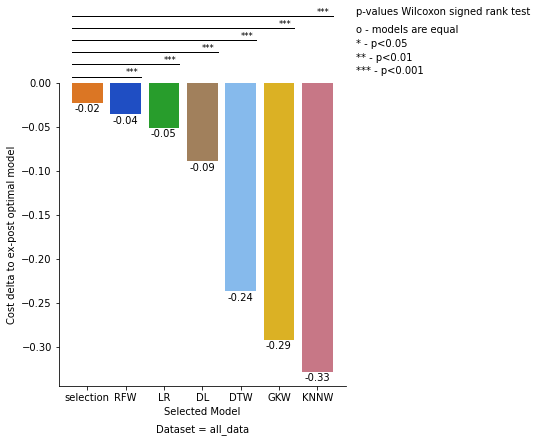

In [157]:
g = sns.catplot(x="Selected Model", y="∆C", data=df_means_all, kind="bar", palette=p)

for ax in g.axes.flatten():
    
    trans = ax.get_xaxis_transform()
    
    ax.title.set_position([.5, -10])
    
    m = [x.get_text() for x in ax.get_xticklabels()]

    # show the values
    for pat in ax.patches:
        h, w, x = pat.get_height(), pat.get_width(), pat.get_x()
        xy = (x + w / 2., h)
        text = f'\n{h:0.2f}'
        ax.annotate(text=text, xy=xy, ha='center', va='center')    
    
    #starting point for lines
    y_lines_base = 1.02
    x_lines_base = 1
    
    # plot p-values
    d='all_data'
    
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[1])),'p_value_star'].item(), xy=(x_lines_base, y_lines_base+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,1.4],[y_lines_base,y_lines_base], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[2])),'p_value_star'].item(), xy=(x_lines_base+1, y_lines_base+0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,2.4],[y_lines_base+0.04,y_lines_base+0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[3])),'p_value_star'].item(), xy=(x_lines_base+2, y_lines_base+2*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,3.4],[y_lines_base+2*0.04,y_lines_base+2*0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[4])),'p_value_star'].item(), xy=(x_lines_base+3, y_lines_base+3*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,4.4],[y_lines_base+3*0.04,y_lines_base+3*0.04], color="k", transform=trans, clip_on=False, linewidth=1)

    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[5])),'p_value_star'].item(), xy=(x_lines_base+4, y_lines_base+4*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,5.4],[y_lines_base+4*0.04,y_lines_base+4*0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[6])),'p_value_star'].item(), xy=(x_lines_base+5, y_lines_base+5*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,6.4],[y_lines_base+5*0.04,y_lines_base+5*0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    
    #move dataset name to bottom of plot 
    ax.annotate(text =f'Dataset = {d}', xy=(3, -0.125), xycoords=trans, ha="center", va="top")
    
    ax.set_ylabel('Cost delta to ex-post optimal model')
    

    y_align = 1.25
    x_align = 7.0
    trans = ax.get_xaxis_transform()
    ax.annotate('p-values Wilcoxon signed rank test', xy=(x_align, y_align), xycoords=trans, ha="left", va="top")
    ax.annotate('o - models are equal', xy=(x_align, y_align-0.06), xycoords=trans, ha="left", va="top")
    ax.annotate('* - p<0.05', xy=(x_align, y_align-0.06-0.045), xycoords=trans, ha="left", va="top")
    ax.annotate('** - p<0.01', xy=(x_align, y_align-0.06-2*0.045), xycoords=trans, ha="left", va="top")
    ax.annotate('*** - p<0.001', xy=(x_align, y_align-0.06-3*0.045), xycoords=trans, ha="left", va="top")

In [158]:
g.savefig(f"Plots/gap_to_optimality_{features}_SL_{SL}.png")  

Text(7.0, 1.055, '*** - p<0.001')

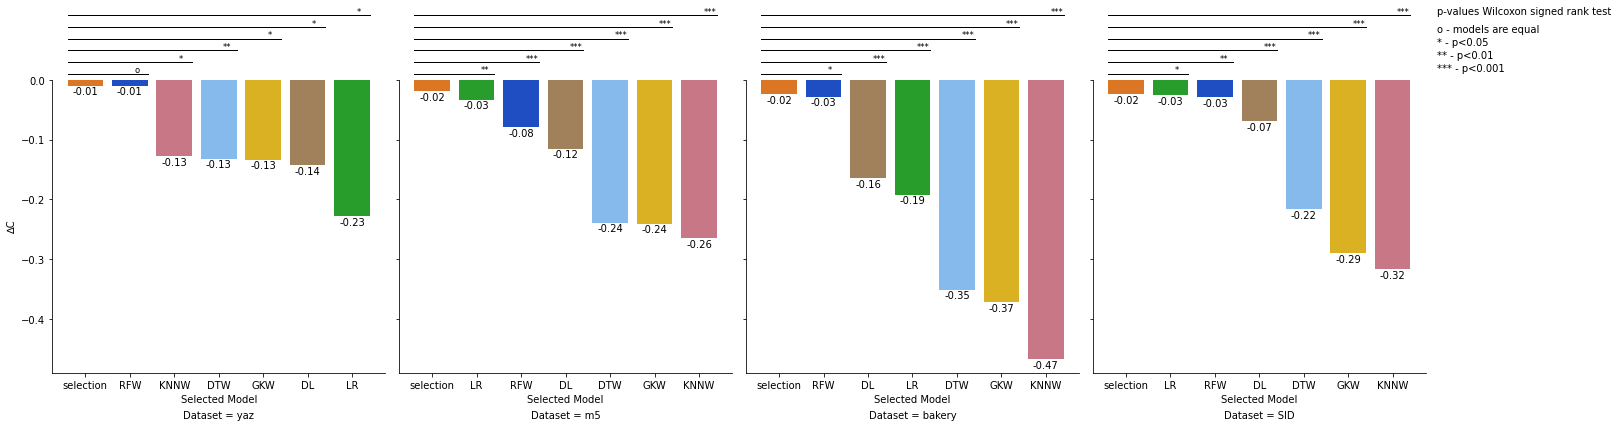

In [161]:
g = sns.catplot(x="Selected Model", y="∆C", data=df_means_dataset, kind="bar", hue="Selected Model", palette=p, 
                col="dataset", sharex=False, dodge=False)

for ax in g.axes.flatten():

    trans = ax.get_xaxis_transform()
    
    ax.title.set_position([.5, -10])
    
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(" ")
    
    m = [x.get_text() for x in ax.get_xticklabels()]

    # show the values
    for pat in ax.patches:
        h, w, x = pat.get_height(), pat.get_width(), pat.get_x()
        xy = (x + w / 2., h)
        text = f'\n{h:0.2f}'
        ax.annotate(text=text, xy=xy, ha='center', va='center')
    
        
    #starting point for lines
    y_lines_base = 1.02
    x_lines_base = 1.1
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[1])),'p_value_star'].item(), xy=(x_lines_base, y_lines_base+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,1.4],[y_lines_base,y_lines_base], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[2])),'p_value_star'].item(), xy=(x_lines_base+1, y_lines_base+0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,2.4],[y_lines_base+0.04,y_lines_base+0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[3])),'p_value_star'].item(), xy=(x_lines_base+2, y_lines_base+2*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,3.4],[y_lines_base+2*0.04,y_lines_base+2*0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[4])),'p_value_star'].item(), xy=(x_lines_base+3, y_lines_base+3*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,4.4],[y_lines_base+3*0.04,y_lines_base+3*0.04], color="k", transform=trans, clip_on=False, linewidth=1)

    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[5])),'p_value_star'].item(), xy=(x_lines_base+4, y_lines_base+4*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,5.4],[y_lines_base+4*0.04,y_lines_base+4*0.04], color="k", transform=trans, clip_on=False, linewidth=1)

    ax.annotate(text = wilcox.loc[((wilcox.Dataset==d)&(wilcox['Selected Model']==m[6])),'p_value_star'].item(), xy=(x_lines_base+5, y_lines_base+5*0.04+0.028), xycoords=trans, ha="left", va="top", fontsize='small')
    ax.plot([-.4,6.4],[y_lines_base+5*0.04,y_lines_base+5*0.04], color="k", transform=trans, clip_on=False, linewidth=1)
    
    #move dataset name to bottom of plot
    
    ax.annotate(text =f'Dataset = {d}', xy=(3, -0.125), xycoords=trans, ha="center", va="top")
    
ax = g.axes.flatten()[-1]
y_align = 1.25
x_align = 7.0
trans = ax.get_xaxis_transform()
ax.annotate('p-values Wilcoxon signed rank test', xy=(x_align, y_align), xycoords=trans, ha="left", va="top")
ax.annotate('o - models are equal', xy=(x_align, y_align-0.06), xycoords=trans, ha="left", va="top")
ax.annotate('* - p<0.05', xy=(x_align, y_align-0.06-0.045), xycoords=trans, ha="left", va="top")
ax.annotate('** - p<0.01', xy=(x_align, y_align-0.06-2*0.045), xycoords=trans, ha="left", va="top")
ax.annotate('*** - p<0.001', xy=(x_align, y_align-0.06-3*0.045), xycoords=trans, ha="left", va="top")

In [162]:
g.savefig(f"Plots/gap_to_optimality_{features}_SL_{SL}_per_dataset.png") 